In [1]:
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
import segmentation_models_pytorch as smp


c:\Users\manjw\.conda\envs\dataEngineering\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 自定义数据集类
class SpineWeb15(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, index):
        metadata = np.load(self.data_path+str(index)+".npy")
        image = metadata[0]
        label = metadata[1]

        image_data = torch.from_numpy(image).float()
        label_data = torch.from_numpy(label).float()
        
        if self.transform:
            image_data = self.transform(image_data)
        return image_data, label_data



Epoch [1/200], Avg Loss: 1.0994, Avg IoU: 0.0162, Avg Dice: 0.0305,Test IoU: 0.1289, Test Dice: 0.2060, Train Acc: 0.4953, Test Acc: 0.7998
Epoch [2/200], Avg Loss: 1.0170, Avg IoU: 0.0338, Avg Dice: 0.0567,Test IoU: 0.1968, Test Dice: 0.3088, Train Acc: 0.8115, Test Acc: 0.8876
Epoch [3/200], Avg Loss: 0.9776, Avg IoU: 0.0276, Avg Dice: 0.0460,Test IoU: 0.1219, Test Dice: 0.1896, Train Acc: 0.8935, Test Acc: 0.9255
Epoch [4/200], Avg Loss: 0.9585, Avg IoU: 0.0158, Avg Dice: 0.0260,Test IoU: 0.1165, Test Dice: 0.1917, Train Acc: 0.9383, Test Acc: 0.9184
Epoch [5/200], Avg Loss: 0.9421, Avg IoU: 0.0125, Avg Dice: 0.0194,Test IoU: 0.0369, Test Dice: 0.0594, Train Acc: 0.9424, Test Acc: 0.9458
Epoch [6/200], Avg Loss: 0.9308, Avg IoU: 0.0147, Avg Dice: 0.0221,Test IoU: 0.0309, Test Dice: 0.0507, Train Acc: 0.9574, Test Acc: 0.9587
Epoch [7/200], Avg Loss: 0.9124, Avg IoU: 0.0311, Avg Dice: 0.0523,Test IoU: 0.0941, Test Dice: 0.1493, Train Acc: 0.9543, Test Acc: 0.9495
Epoch [8/200], Avg L

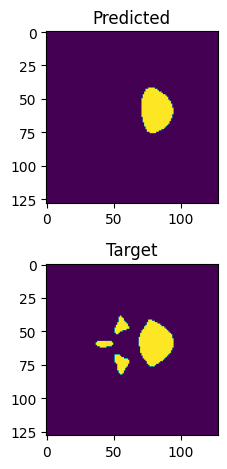

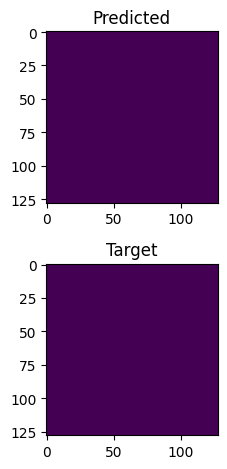

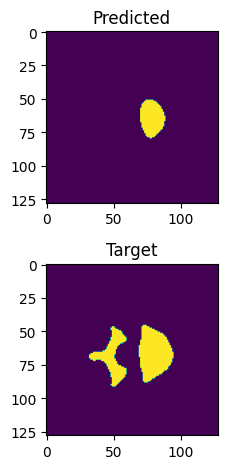

Epoch [161/200], Avg Loss: 0.6904, Avg IoU: 0.2749, Avg Dice: 0.3298,Test IoU: 0.1639, Test Dice: 0.2504, Train Acc: 0.9926, Test Acc: 0.9657
Epoch [162/200], Avg Loss: 0.6914, Avg IoU: 0.3580, Avg Dice: 0.4362,Test IoU: 0.1231, Test Dice: 0.1996, Train Acc: 0.9932, Test Acc: 0.9581
Epoch [163/200], Avg Loss: 0.6929, Avg IoU: 0.2637, Avg Dice: 0.3225,Test IoU: 0.1015, Test Dice: 0.1690, Train Acc: 0.9909, Test Acc: 0.9491
Epoch [164/200], Avg Loss: 0.6902, Avg IoU: 0.2598, Avg Dice: 0.3554,Test IoU: 0.1154, Test Dice: 0.1888, Train Acc: 0.9854, Test Acc: 0.9574
Epoch [165/200], Avg Loss: 0.6945, Avg IoU: 0.1609, Avg Dice: 0.2310,Test IoU: 0.1641, Test Dice: 0.2682, Train Acc: 0.9900, Test Acc: 0.9523
Epoch [166/200], Avg Loss: 0.6899, Avg IoU: 0.2072, Avg Dice: 0.2963,Test IoU: 0.1630, Test Dice: 0.2467, Train Acc: 0.9800, Test Acc: 0.9707
Epoch [167/200], Avg Loss: 0.6916, Avg IoU: 0.2425, Avg Dice: 0.2891,Test IoU: 0.2002, Test Dice: 0.2859, Train Acc: 0.9927, Test Acc: 0.9734
Epoch 

In [13]:
# -----------------------------
# UNet Train and Test Set
# -----------------------------

def calculate_pixel_accuracy(prediction, target):
    # 将预测结果和目标标签进行逐像素比较，并计算正确预测像素的比例
    correct_pixels = (prediction == target).sum().item()
    total_pixels = target.numel()
    accuracy = correct_pixels / total_pixels
    return accuracy

def calculate_iou(prediction, target):
    intersection = torch.logical_and(prediction, target).sum()
    union = torch.logical_or(prediction, target).sum()
    iou = intersection / union
    return iou.item()

def calculate_dice(prediction, target):
    intersection = torch.logical_and(prediction, target).sum()
    dice = (2 * intersection) / (prediction.sum() + target.sum())
    return dice.item()

# empty the cache for model and training process
torch.cuda.empty_cache()

# set the hyper parameters and the paths 设置超参数和路径
data_path = "./dataset/Spineweb_dataset15/train/"
test_path = "./dataset/Spineweb_dataset15/test/"

#hyper parameters set
batch_size = 32
num_epochs = 200
learning_rate = 0.001
confidence = 0.7
in_channels = 1  # according to demand to adjust the number of channels 根据实际情况修改通道数
out_channels = 1  # according to demand to adjust the number of channels 根据实际情况修改通道数

# 创建数据集和数据加载器
transform = transforms.Compose([
    transforms.ToPILImage(),  # 转换为 PIL 图像对象
    transforms.Resize((128, 128)),  # 调整大小为 128x128
    transforms.ToTensor()  # 转换为张量
])
dataset = SpineWeb15(data_path=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
testset = SpineWeb15(data_path=test_path, transform=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

# 创建模型和优化器
model = smp.UnetPlusPlus(encoder_name='resnet34', encoder_depth=5, encoder_weights=None, decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=1, classes=1, activation=None, aux_params=None)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()  # 二分类任务可以使用BCEWithLogitsLoss
# criterion = DiceLoss(mode="binary")   #DiceLoss
# criterion = FocalLoss(mode="binary")
# criterion = smp.losses.TverskyLoss(mode="binary")

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# check the parameters of the model could be trained 检查模型的参数是否设置为可训练
# for name, param in model.named_parameters():
#     print(f"Parameter: {name}, Requires Grad: {param.requires_grad}")

best_loss_train = 100.0
best_IoU_train = 0.0
best_Dice_train = 0.0

best_IoU_test = 0.0
best_Dice_test = 0.0

best_acc_train = 0.0
best_acc_test = 0.0

# 训练模型
for epoch in range(num_epochs):
    # torch.cuda.empty_cache()
    model.train()
    train_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_iou_test = 0.0
    total_dice_test = 0.0
    total_acc_train = 0.0
    total_acc_test = 0.0

    if epoch > 100:
        confidence = 0.9

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()

        outputs = model(images)
        # squeeze the dimension that pytorch add for channels
        outputs = outputs.squeeze(1)     # tensor size ([16,128,128])
        # apply sigmoid on the outputs
        outputs = torch.sigmoid(outputs)
        # process the result, bigger than confidence is reliable
        predicted = (outputs > confidence).float()     # tensor size ([16,128,128]), True->1.0 and False->0.0
        intersection = torch.logical_and(predicted, labels).sum((1, 2))
        union = torch.logical_or(predicted, labels).sum((1, 2))
        iou = (intersection / (union + 1e-7)).mean()  # 平均每个样本的IoU
        dice = (2 * intersection / (predicted.sum((1, 2)) + labels.sum((1, 2)) + 1e-7)).mean()  # 平均每个样本的Dice Coefficient
        # 计算训练集的像素精度
        acc_train = calculate_pixel_accuracy(predicted, labels)

        loss = criterion(outputs, labels)

        train_loss += loss.item()
        total_iou += iou.item()
        total_dice += dice.item()
        total_acc_train += acc_train

        loss.backward()
        optimizer.step()

        # if epoch == 160:
        #     predicted_npimage = predicted[0].detach().cpu().numpy()
        #     targets_npimage = labels[0].detach().cpu().numpy()
        #     fig, axes = plt.subplots(2, 1)
        #     axes[0].imshow(predicted_npimage)
        #     axes[0].set_title('Predicted')
        #     axes[1].imshow(targets_npimage)
        #     axes[1].set_title('Target')
        #     plt.tight_layout()
        #     plt.show()

    # train set results
    avg_loss = train_loss / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    avg_acc_train = total_acc_train / len(dataloader)

    # test set results
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            # squeeze the dimension that pytorch add for channels
            outputs = outputs.squeeze(1)     # tensor size ([16,128,128])
            outputs = torch.sigmoid(outputs)
            # process the result, bigger than 0.5 is reliable
            predicted = (outputs > confidence).float()     # tensor size ([16,128,128])
            intersection = torch.logical_and(predicted, targets).sum((1, 2))
            union = torch.logical_or(predicted, targets).sum((1, 2))
            iou = (intersection / (union + 1e-7)).mean()  # 平均每个样本的IoU
            dice = (2 * intersection / (predicted.sum((1, 2)) + targets.sum((1, 2)) + 1e-7)).mean()  # 平均每个样本的Dice Coefficient


            acc_test = calculate_pixel_accuracy(predicted, targets)
            total_iou_test += iou.item()
            total_dice_test += dice.item()
            total_acc_test += acc_test

        if epoch == 160:
            predicted_npimage = predicted[0].detach().cpu().numpy()
            targets_npimage = targets[0].detach().cpu().numpy()
            fig, axes = plt.subplots(2, 1)
            axes[0].imshow(predicted_npimage)
            axes[0].set_title('Predicted')
            axes[1].imshow(targets_npimage)
            axes[1].set_title('Target')
            plt.tight_layout()
            plt.show()

    test_iou = total_iou_test / len(test_loader)
    test_dice = total_dice_test / len(test_loader)
    test_acc = total_acc_test / len(test_loader)

    # get the best IoU and Dice
    best_loss_train = best_loss_train if best_loss_train < avg_loss else avg_loss
    best_IoU_train = best_IoU_train if best_IoU_train > avg_iou else avg_iou
    best_Dice_train = best_Dice_train if best_Dice_train > avg_dice else avg_dice
    best_IoU_test = best_IoU_test if best_IoU_test > test_iou else test_iou
    # best_Dice_test = best_Dice_test if best_Dice_test > test_dice else test_dice

    if(best_Dice_test <= test_dice):
        best_Dice_test = test_dice
        torch.save(model.state_dict(), f"./model/UNet++_checkpoint.pth")

    # get the best accuracy of the trainloader and testloader
    best_acc_train = best_acc_train if best_acc_train > avg_acc_train else avg_acc_train
    best_acc_test = best_acc_test if best_acc_test > test_acc else test_acc

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f},Test IoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}, Train Acc: {avg_acc_train:.4f}, Test Acc: {test_acc:.4f}")
    
print("-----------------------------------------")
print(f"Best Loss: {best_loss_train:.4f}, Best Train IoU: {best_IoU_train:.4f}, Best Train Dice: {best_Dice_train:.4f}, Best Test IoU: {best_IoU_test:.4f}, Best Test Dice: {best_Dice_test:.4f}, Best Train Acc: {best_acc_train:.4f}, Best Test Acc: {best_acc_test:.4f}")
# empty the cache for model and training process
torch.cuda.empty_cache()

In [25]:
# -----------------------------
# UNet++ All Set
# -----------------------------

# empty the cache for model and training process
torch.cuda.empty_cache()

# set the hyper parameters and the paths 设置超参数和路径
data_path = "./dataset/Spineweb_dataset15/processed/"

#hyper parameters set
batch_size = 32
num_epochs = 1
learning_rate = 0.0001
confidence = 0.8
in_channels = 1  # according to demand to adjust the number of channels 根据实际情况修改通道数
out_channels = 1  # according to demand to adjust the number of channels 根据实际情况修改通道数

# 创建数据集和数据加载器
transform = transforms.Compose([
    transforms.ToPILImage(),  # 转换为 PIL 图像对象
    transforms.Resize((128, 128)),  # 调整大小为 128x128
    transforms.ToTensor()  # 转换为张量
])
dataset = SpineWeb15(data_path=data_path,transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 创建模型和优化器
model = smp.UnetPlusPlus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=1, classes=1, activation=None, aux_params=None)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.BCEWithLogitsLoss()  # 二分类任务可以使用BCEWithLogitsLoss
criterion = smp.losses.TverskyLoss(mode="binary")

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# check the parameters of the model could be trained 检查模型的参数是否设置为可训练
# for name, param in model.named_parameters():
#     print(f"Parameter: {name}, Requires Grad: {param.requires_grad}")

best_loss = 100.0
best_IoU = 0.0
best_Dice = 0.0

# 训练模型
for epoch in range(num_epochs):
    # torch.cuda.empty_cache()
    model.train()
    train_loss = 0
    total_iou = 0
    total_dice = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()

        outputs = model(images)
        # squeeze the dimension that pytorch add for channels
        outputs = outputs.squeeze(1)     # tensor size ([16,128,128])
        outputs = torch.sigmoid(outputs)
        # process the result, bigger than 0.5 is reliable
        predicted = (outputs > confidence).float()     # tensor size ([16,128,128])
        
        intersection = torch.logical_and(predicted, labels).sum((1, 2))
        union = torch.logical_or(predicted, labels).sum((1, 2))
        iou = (intersection / (union + 1e-7)).mean()  # 平均每个样本的IoU
        dice = (2 * intersection / (predicted.sum((1, 2)) + labels.sum((1, 2)) + 1e-7)).mean()  # 平均每个样本的Dice Coefficient

        loss = criterion(outputs, labels)

        train_loss += loss.item()
        total_iou += iou.item()
        total_dice += dice.item()

        loss.backward()
        optimizer.step()

    avg_loss = train_loss / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    
    # get the best IoU and Dice
    best_loss = best_loss if best_loss < avg_loss else avg_loss
    best_IoU = best_IoU if best_IoU > avg_iou else avg_iou
    best_Dice = best_Dice if best_Dice > avg_dice else avg_dice

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}")
print("-----------------------------------------")
print(f"Best Loss: {best_loss:.4f}, Best IoU: {best_IoU:.4f}, Best Dice: {best_Dice:.4f}")
# empty the cache for model and training process
torch.cuda.empty_cache()

Epoch [1/1], Avg Loss: 0.9406, Avg IoU: 0.0078, Avg Dice: 0.0153
-----------------------------------------
Best Loss: 0.9406, Best IoU: 0.0078, Best Dice: 0.0153
